# Traffic information Netherlands
The intention of this Python script is to scrape actual travel information about expected delays.
The first part will do this for traffic, the second part can do this for trains.

Source: https://www.anwb.nl/feeds/gethf

### Init all necessary libraries

In [55]:
# Load packages into memory
import requests
import json
import pandas as pd
import seaborn as sns

from pandas.io.json import json_normalize

from tinydb import TinyDB

dbname='traffic_db.json'

### Retrieve collected raw data

In [56]:
# Let's get the current VAT rate in the EU
dbname='traffic_db.json'
db = TinyDB(dbname)

all_data = db.all()

# Pandas version 0.25 contains new parameter max_level in json_normalize.
pd.__version__

'0.24.2'

### Translate JSON data into dataframe (separate parsing from data collection)

In [57]:
traffic_data = pd.DataFrame()

for jso in all_data:# Create json object from returned text
    #jso = json.loads(routeInfo.text)
    # Create dataframe from json object roadEntries
    trafficdf = json_normalize(jso['roadEntries'])

    # Drop unnecessary columns (I did not find any documentation about the webservice yet to only retrieve what I need.)
    trafficdf.drop(columns = ['events.roadWorks','events.radars'],inplace=True)

    # Read the number of trafficJams and filter the dataframe on it.
    trafficdf['listlength'] = trafficdf['events.trafficJams'].apply(lambda x : len(x))
    trafficdf = trafficdf[trafficdf['listlength'] > 0]
    trafficdf.drop(columns = ['listlength'], inplace=True)
    trafficdf['timestap'] = datetime.now()

    # Pop all trafficjams, normalize and join back to dataframe to keep road info.
    trafficdf = (pd.concat({i: json_normalize(x) for i, x in trafficdf.pop('events.trafficJams').items()}, sort=True)
             .reset_index(level=1, drop=True)
             .join(trafficdf)
             .reset_index(drop=True))

    # Drop all items where no delays are mentioned.
    trafficdf = trafficdf.dropna()
    trafficdf.drop(columns=['events'],inplace=True)

    # Set index to msgNr.
    #trafficdf.set_index('msgNr', inplace=True)
    traffic_data=traffic_data.append(trafficdf)
    #trafficdf.tail()

### Have a look at trafficinfo

In [58]:
print(traffic_data.count())

traffic_data.tail()

delay          47
description    47
distance       47
from           47
fromLoc.lat    47
fromLoc.lon    47
location       47
msgNr          47
reason         47
segEnd         47
segStart       47
start          47
startDate      47
to             47
toLoc.lat      47
toLoc.lon      47
road           47
roadType       47
timestap       47
dtype: int64


,delay,description,distance,from,fromLoc.lat,fromLoc.lon,location,msgNr,reason,segEnd,segStart,start,startDate,to,toLoc.lat,toLoc.lon,road,roadType,timestap
8,240.0,Tussen Sliedrecht-West en Hardinxveld-Giessend...,3000.0,Sliedrecht-West,51.83156,4.74547,A15 Rotterdam richting Gorinchem,208179947,,Gorinchem,Rotterdam,2019-10-10T10:51:00,10 oktober 2019 12:51 uur,Hardinxveld-Giessendam,51.82443,4.84649,A15,aWegen,2019-10-10 13:16:54.076998
9,240.0,Tussen Breda-Noord en knp. Sint Annabosch.,2800.0,Breda-Noord,51.59227,4.82889,A27 Gorinchem richting Breda,208179946,,Breda,Gorinchem,2019-10-10T09:49:00,10 oktober 2019 11:49 uur,knp. Sint Annabosch,51.55451,4.84305,A27,aWegen,2019-10-10 13:16:54.076998
10,2040.0,Tussen Oss-Oost en Ravenstein. Door een ongeluk.,8100.0,Oss-Oost,51.72743,5.57317,A50 Eindhoven richting Arnhem,208179938,Door een ongeluk.,Arnhem,Eindhoven,2019-10-10T10:25:30,10 oktober 2019 12:25 uur,Ravenstein,51.78808,5.65334,A50,aWegen,2019-10-10 13:16:54.076998
11,2640.0,Tussen Tilburg-Centrum West en Ulvenhout. Door...,12000.0,Tilburg-Centrum West,51.53947,5.04758,A58 Tilburg richting Breda,208179936,Door opruimwerkzaamheden. De rechterrijstrook ...,Breda,Tilburg,2019-10-10T09:36:00,10 oktober 2019 11:36 uur,Ulvenhout,51.53705,4.79833,A58,aWegen,2019-10-10 13:16:54.076998
12,660.0,Tussen afrit Dussen en knp. Hooipolder.,4200.0,afrit Dussen,51.69544,4.98807,A59 Oss richting knp. Zonzeel,208179940,,knp. Zonzeel,Oss,2019-10-10T10:11:00,10 oktober 2019 12:11 uur,knp. Hooipolder,51.68725,4.88382,A59,aWegen,2019-10-10 13:16:54.076998


In [59]:
traffic_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47 entries, 1 to 12
Data columns (total 19 columns):
delay          47 non-null float64
description    47 non-null object
distance       47 non-null float64
from           47 non-null object
fromLoc.lat    47 non-null float64
fromLoc.lon    47 non-null float64
location       47 non-null object
msgNr          47 non-null object
reason         47 non-null object
segEnd         47 non-null object
segStart       47 non-null object
start          47 non-null object
startDate      47 non-null object
to             47 non-null object
toLoc.lat      47 non-null float64
toLoc.lon      47 non-null float64
road           47 non-null object
roadType       47 non-null object
timestap       47 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(6), object(12)
memory usage: 7.3+ KB


Text(0.5, 1.0, 'Actual Delays')

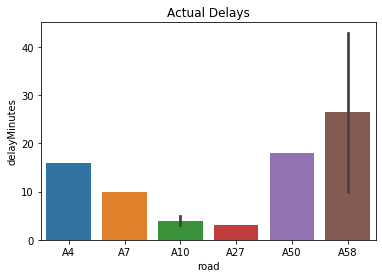

In [60]:
latestTimestamp = dftest.timestap.max()
#dftest[dftest['timestap']==latestTimestamp].plot(x='start',y='delay')
#dftest.plot(x='timestap',y='delay')
dftest['delayMinutes'] = dftest['delay'] / 60
bp = sns.barplot(x='road',y='delayMinutes',data=dftest[dftest['timestap']==latestTimestamp])
#bp.set_xticklabels(bp.get_xticklabels(), rotation=90)
bp.set_title('Actual Delays')

### Push dataframe to Azure SQL, based on index

params = 'DRIVER={SQL Server};' \
         'SERVER=****;' \
         'PORT=1433;' \
         'DATABASE=o365data;' \
         'UID=****;' \
         'PWD=****;'
            
params = urllib.parse.quote_plus(params)

engine = create_engine("mssql+pyodbc:///?odbc_connect=%s" % params)

%time trafficdf.to_sql(name='TrafficInformation',con=engine , schema='dbo', if_exists='append', index=False)